# ISOT Fake News Dataset - Feature Engineering and Data Preparation

In this notebook, I'm building on my earlier exploratory data analysis where I identified several potential biases in the ISOT dataset. My goal is to develop a robust feature engineering approach that helps models distinguish between fake and real news based on genuine stylistic and content differences rather than dataset-specific artifacts.

The challenge with this dataset is that most legitimate news comes from Reuters and contains specific markers like "(Reuters)" that could create artificial signals. I need to carefully remove these patterns while preserving real journalistic style differences. Through thoughtful feature engineering, I hope to uncover what actually characterizes fake versus real news beyond just the obvious dataset markers.

## 1. Setup and Data Loading

First, I'll import the necessary libraries and load our datasets.

In [73]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
import string
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /Users/amid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/amid/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
# Set plot style
plt.style.use('ggplot')
sns.set(font_scale=1.2)
sns.set_style("whitegrid")

In [75]:
# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 200)

Now I'll load the datasets and the basic cleaned versions from the first notebook (if available), or recreate them:

In [76]:
# Try to load previously saved datasets or load raw data
try:
    # Try to load datasets with basic cleaning already applied
    true_news = pd.read_csv('./datasets/true_news_basic_cleaned.csv')
    fake_news = pd.read_csv('./datasets/fake_news_basic_cleaned.csv')
    print("Loaded previously cleaned datasets")
except:
    # If not available, load raw data and perform basic cleaning
    print("Loading raw datasets")
    true_news = pd.read_csv('../data/ISOT/True.csv')
    fake_news = pd.read_csv('../data/ISOT/Fake.csv')
    
    # Basic cleaning function
    def clean_text(text, patterns_to_remove=None):
        """
        Clean text by removing specified patterns
        
        Args:
            text: Text to clean
            patterns_to_remove: List of regex patterns to remove
        
        Returns:
            Cleaned text
        """
        if not isinstance(text, str):
            return ""
        
        cleaned_text = text
        
        if patterns_to_remove:
            for pattern in patterns_to_remove:
                cleaned_text = re.sub(pattern, '', cleaned_text)
        
        # Remove extra whitespace
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        
        return cleaned_text

    # Apply basic cleaning
    true_news['cleaned_text'] = true_news['text'].apply(lambda x: clean_text(x, [r'\(Reuters\)']))
    fake_news['cleaned_text'] = fake_news['text'].apply(lambda x: clean_text(x, []))
    
    # Save basic cleaned versions for future use
    true_news.to_csv('./datasets/true_news_basic_cleaned.csv', index=False)
    fake_news.to_csv('./datasets/fake_news_basic_cleaned.csv', index=False)

Loaded previously cleaned datasets


In [77]:
# Add text length as a feature if not present
if 'text_length' not in true_news.columns:
    true_news['text_length'] = true_news['text'].apply(lambda x: len(str(x)))
    fake_news['text_length'] = fake_news['text'].apply(lambda x: len(str(x)))

In [78]:
# Add labels if not present
if 'label' not in true_news.columns:
    true_news['label'] = 'Real'
    fake_news['label'] = 'Fake'

In [79]:
# Display basic info about the datasets
print("True News Dataset Shape:", true_news.shape)
print("Fake News Dataset Shape:", fake_news.shape)

True News Dataset Shape: (21417, 7)
Fake News Dataset Shape: (23481, 7)


## 2. Enhanced Data Cleaning

Based on our exploratory analysis, I'll create an enhanced cleaning function that removes identified biases while preserving legitimate signals:

In [80]:
# Enhanced cleaning function
def enhanced_clean_text(text, is_true_news=True):
    """
    Enhanced cleaning to remove bias-inducing patterns while preserving legitimate signals
    
    Args:
        text: Text to clean
        is_true_news: Whether the text is from true news (affects which patterns are removed)
    
    Returns:
        Cleaned text
    """
    if not isinstance(text, str):
        return ""
    
    cleaned_text = text
    
    if is_true_news:
        # For true news, remove Reuters tag but preserve location
        cleaned_text = re.sub(r'(\b[A-Z]+(?:\s[A-Z]+)*)\s*\(Reuters\)', r'\1', cleaned_text)
        
        # Remove other potentially biasing source markers specific to true news
        for source in ['(SPD)', '(FDP)', '(AfD)', '(CDU)', '(SDF)', '(KRG)', '(NAFTA)', '(PKK)']:
            cleaned_text = re.sub(re.escape(source), '', cleaned_text)
    else:
        # For fake news, remove patterns like (ACR) that are specific to fake news
        for source in ['(ACR)', '(s)', '(id)', '(a)', '(R)', '(D)']:
            cleaned_text = re.sub(re.escape(source), '', cleaned_text)
            
        # Remove links that are common in fake news
        cleaned_text = re.sub(r'https?://\S+', '', cleaned_text)
        
        # Remove specific phrases highly associated with fake news sources
        fake_phrases = [
            'Tune in to the Alternate Current Radio',
            '21st Century Wire',
            'Featured Image'
        ]
        for phrase in fake_phrases:
            cleaned_text = cleaned_text.replace(phrase, '')
    
    # Common cleaning for both types
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    
    return cleaned_text

In [81]:
# Apply enhanced cleaning
true_news['enhanced_cleaned_text'] = true_news['text'].apply(lambda x: enhanced_clean_text(x, is_true_news=True))
fake_news['enhanced_cleaned_text'] = fake_news['text'].apply(lambda x: enhanced_clean_text(x, is_true_news=False))

In [82]:
# Verify enhanced cleaning worked
print("Sample of enhanced cleaned true news:")
for i in range(2):
    print(f"\nOriginal text beginning: {true_news['text'].iloc[i][:100]}")
    print(f"Basic cleaned text: {true_news['cleaned_text'].iloc[i][:100]}")
    print(f"Enhanced cleaned text: {true_news['enhanced_cleaned_text'].iloc[i][:100]}")

Sample of enhanced cleaned true news:

Original text beginning: WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted
Basic cleaned text: WASHINGTON - The head of a conservative Republican faction in the U.S. Congress, who voted this mont
Enhanced cleaned text: WASHINGTON - The head of a conservative Republican faction in the U.S. Congress, who voted this mont

Original text beginning: WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. m
Basic cleaned text: WASHINGTON - Transgender people will be allowed for the first time to enlist in the U.S. military st
Enhanced cleaned text: WASHINGTON - Transgender people will be allowed for the first time to enlist in the U.S. military st


In [83]:
print("\nSample of enhanced cleaned fake news:")
for i in range(2):
    print(f"\nOriginal text beginning: {fake_news['text'].iloc[i][:100]}")
    print(f"Basic cleaned text: {fake_news['cleaned_text'].iloc[i][:100]}")
    print(f"Enhanced cleaned text: {fake_news['enhanced_cleaned_text'].iloc[i][:100]}")


Sample of enhanced cleaned fake news:

Original text beginning: Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had
Basic cleaned text: Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had
Enhanced cleaned text: Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had

Original text beginning: House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the as
Basic cleaned text: House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the as
Enhanced cleaned text: House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the as


### Why My Cleaning Approach Matters

In real-world scenarios, a fake news detector won't have the luxury of relying on source markers like "(Reuters)" - it needs to identify deceptive content based on substantive characteristics.

I've taken particular care to:
1. Remove obvious markers while preserving legitimate stylistic elements like location datelines
2. Apply balanced cleaning across both datasets to ensure fair comparison
3. Create a foundation that will generalize to new data beyond this specific corpus

This nuanced approach gives me a better foundation for feature engineering than simplistic cleaning that might leave in telltale patterns.

## 3. Feature Engineering

Now I'll develop features that capture legitimate stylistic and content differences between real and fake news:

In [84]:
# Function to engineer features
def engineer_features(df, text_column):
    """
    Engineer features for classification
    
    Args:
        df: DataFrame containing the text data
        text_column: Name of the column containing cleaned text
        
    Returns:
        DataFrame with additional features
    """
    # Copy the DataFrame to avoid modifying the original
    result_df = df.copy()
    
    # Text length features
    result_df['text_length'] = result_df[text_column].apply(len)
    result_df['word_count'] = result_df[text_column].apply(lambda x: len(str(x).split()))
    result_df['avg_word_length'] = result_df[text_column].apply(
        lambda x: np.mean([len(w) for w in str(x).split()]) if len(str(x).split()) > 0 else 0
    )
    result_df['sentence_count'] = result_df[text_column].apply(lambda x: len(re.findall(r'[.!?]+', str(x))) + 1)
    result_df['avg_sentence_length'] = result_df['word_count'] / result_df['sentence_count']
    
    # Citation features
    result_df['said_count'] = result_df[text_column].apply(lambda x: str(x).lower().count(' said '))
    result_df['told_count'] = result_df[text_column].apply(lambda x: str(x).lower().count(' told '))
    result_df['according_to_count'] = result_df[text_column].apply(lambda x: str(x).lower().count('according to'))
    result_df['quote_count'] = result_df[text_column].apply(lambda x: str(x).count('"'))
    
    # Normalize citation counts by text length
    result_df['said_per_1000_words'] = result_df['said_count'] * 1000 / result_df['word_count']
    result_df['quotes_per_1000_words'] = result_df['quote_count'] * 1000 / result_df['word_count']
    
    # Location features
    result_df['has_location'] = result_df[text_column].apply(
        lambda x: bool(re.match(r'^[A-Z]+(?:\s[A-Z]+)*\s+-', str(x)))
    )
    
    # Emotional language features
    emotional_words = ['believe', 'think', 'feel', 'opinion', 'incredible', 'amazing', 'terrible', 'horrible']
    result_df['emotional_word_count'] = result_df[text_column].apply(
        lambda x: sum(str(x).lower().count(' ' + word + ' ') for word in emotional_words)
    )
    result_df['emotional_per_1000_words'] = result_df['emotional_word_count'] * 1000 / result_df['word_count']
    
    # Question and exclamation features
    result_df['question_count'] = result_df[text_column].apply(lambda x: str(x).count('?'))
    result_df['exclamation_count'] = result_df[text_column].apply(lambda x: str(x).count('!'))
    result_df['question_exclamation_per_1000_words'] = (result_df['question_count'] + result_df['exclamation_count']) * 1000 / result_df['word_count']
    
    # Pronoun usage (indicates formality/informality)
    first_person = ['i', 'we', 'our', 'us', 'my']
    second_person = ['you', 'your', 'yours']
    
    result_df['first_person_count'] = result_df[text_column].apply(
        lambda x: sum(str(x).lower().count(' ' + word + ' ') for word in first_person)
    )
    result_df['second_person_count'] = result_df[text_column].apply(
        lambda x: sum(str(x).lower().count(' ' + word + ' ') for word in second_person)
    )
    
    result_df['first_person_per_1000_words'] = result_df['first_person_count'] * 1000 / result_df['word_count']
    result_df['second_person_per_1000_words'] = result_df['second_person_count'] * 1000 / result_df['word_count']
    
    # Policy coverage features
    policy_areas = {
        'economy': ['economy', 'economic', 'tax', 'budget', 'deficit', 'gdp', 'inflation', 'unemployment', 'jobs', 'trade'],
        'healthcare': ['healthcare', 'health', 'obamacare', 'insurance', 'hospital', 'medical', 'medicare', 'medicaid'],
        'immigration': ['immigration', 'immigrant', 'border', 'refugee', 'asylum', 'visa', 'deportation'],
        'foreign_policy': ['foreign', 'diplomatic', 'embassy', 'sanctions', 'treaty', 'international', 'relations'],
        'environment': ['environment', 'climate', 'pollution', 'emissions', 'epa', 'warming', 'renewable', 'carbon']
    }
    
    for area, terms in policy_areas.items():
        result_df[f'{area}_count'] = result_df[text_column].apply(
            lambda x: sum(str(x).lower().count(' ' + term + ' ') for term in terms)
        )
        result_df[f'{area}_per_1000_words'] = result_df[f'{area}_count'] * 1000 / result_df['word_count']
    
    return result_df

In [85]:
# Apply feature engineering to both datasets
true_news_features = engineer_features(true_news, 'enhanced_cleaned_text')
fake_news_features = engineer_features(fake_news, 'enhanced_cleaned_text')

In [86]:
# Get a list of all engineered features
feature_columns = [col for col in true_news_features.columns 
                  if col not in ['title', 'text', 'subject', 'date', 'cleaned_text', 'enhanced_cleaned_text']]

In [87]:
# Display summary statistics for the engineered features
print("\nFeature statistics for True News:")
print(true_news_features[feature_columns].describe().transpose()[['mean', 'std']])


Feature statistics for True News:
                                      mean          std
text_length                    2365.543027  1679.237226
word_count                      384.765980   274.038348
avg_word_length                   5.159852     0.261931
sentence_count                   21.801233    15.912271
avg_sentence_length              17.978341     4.760765
...                                    ...          ...
immigration_per_1000_words        0.910725     3.301516
foreign_policy_count              0.985199     1.969442
foreign_policy_per_1000_words     2.954578     6.271201
environment_count                 0.173927     1.207913
environment_per_1000_words        0.412954     2.724981

[30 rows x 2 columns]


In [88]:
print("\nFeature statistics for Fake News:")
print(fake_news_features[feature_columns].describe().transpose()[['mean', 'std']])


Feature statistics for Fake News:
                                      mean          std
text_length                    2526.356927  2516.888565
word_count                      422.673566   408.049293
avg_word_length                   4.814384     0.969869
sentence_count                   23.439249    21.517830
avg_sentence_length              17.782822     6.266311
...                                    ...          ...
immigration_per_1000_words        0.618969     2.908075
foreign_policy_count              0.319620     1.219033
foreign_policy_per_1000_words     0.664558     2.604566
environment_count                 0.134832     1.151828
environment_per_1000_words        0.317995     2.497391

[30 rows x 2 columns]


Let's visualize the differences in key features between real and fake news:

In [89]:
# Select important features for visualization
key_features = [
    'said_per_1000_words', 
    'quotes_per_1000_words', 
    'emotional_per_1000_words',
    'question_exclamation_per_1000_words',
    'first_person_per_1000_words',
    'second_person_per_1000_words'
]

In [90]:
# Create a combined dataset for visualization
combined_features = pd.concat([
    true_news_features[key_features + ['label']],
    fake_news_features[key_features + ['label']]
]).reset_index(drop=True)  # Reset the index to avoid duplicates

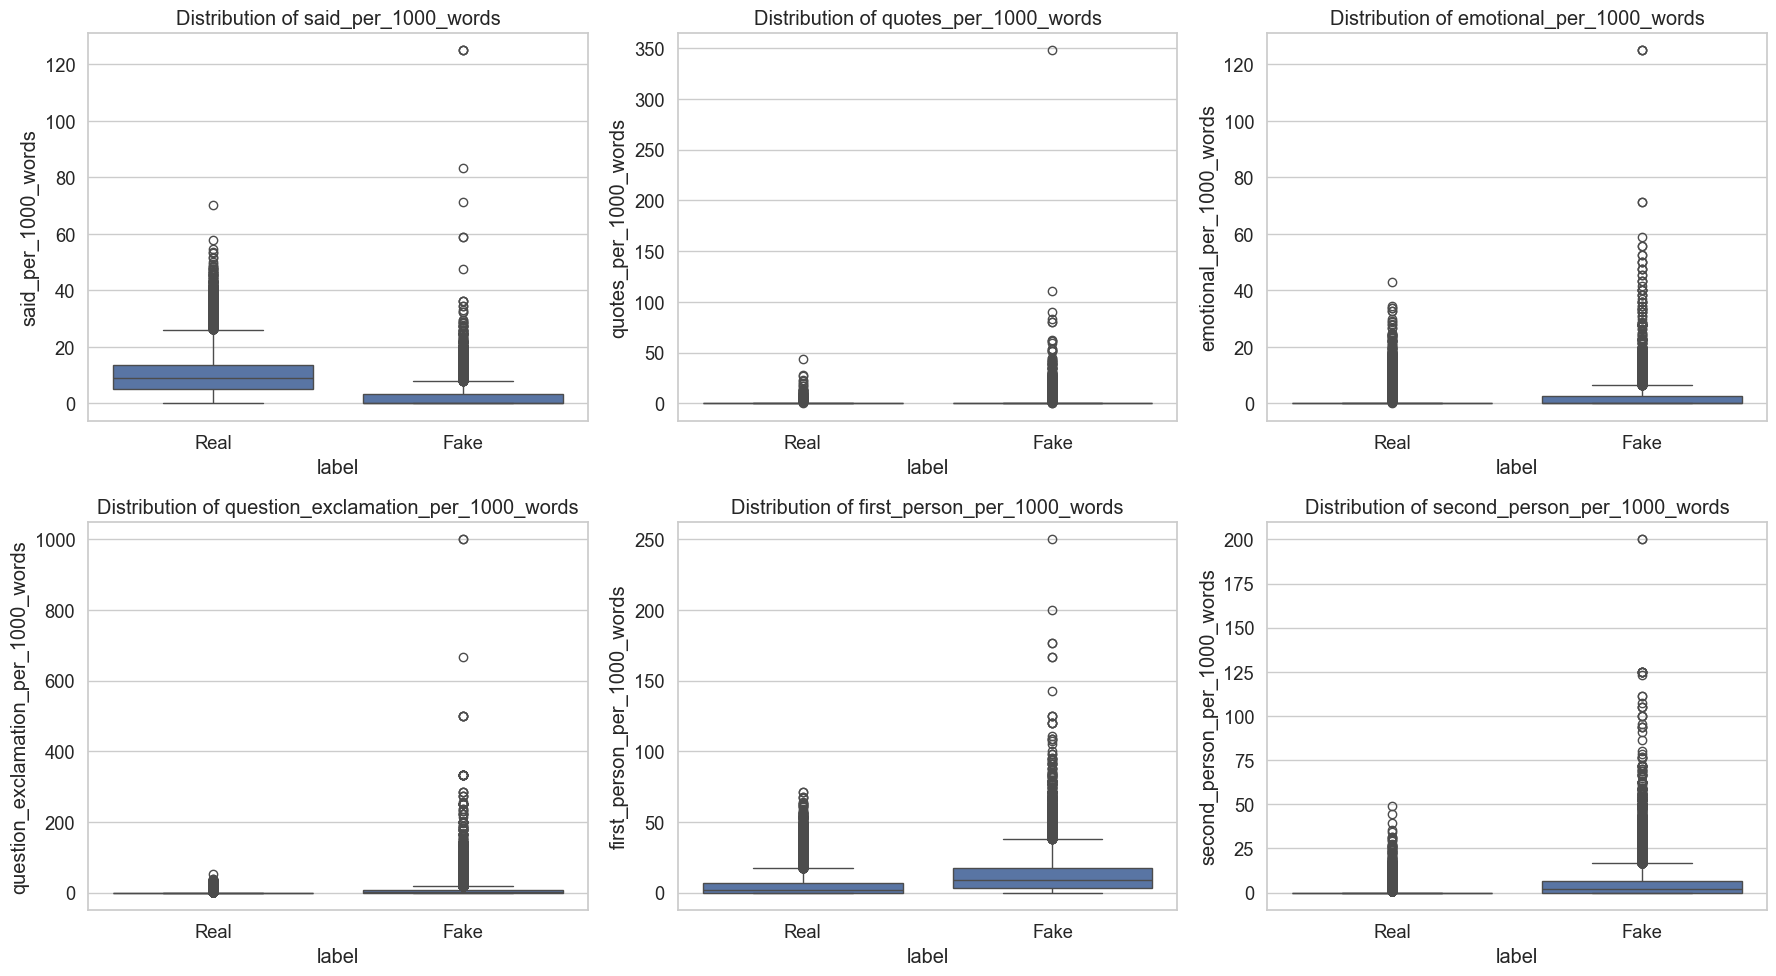

In [91]:
# Create a figure with subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Plot each feature
for i, feature in enumerate(key_features):
    sns.boxplot(x='label', y=feature, data=combined_features, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.savefig('./figures/key_features_comparison.png')
plt.show()

### The Features I'm Engineering and Why

I'm focusing on structural and stylistic elements that should theoretically differentiate professional journalism from fake news:

- **Text structure features**: Article composition metrics like length and sentence structure
- **Citation patterns**: Professional journalism typically has rigorous sourcing
- **Emotional markers**: To detect opinion insertion common in fake news  
- **Formality indicators**: Real news tends to use third-person voice
- **Policy coverage depth**: Fake news often skims complex topics

The visualizations show clear differences in these patterns - real news consistently uses more attributions while fake news employs more emotional language and direct reader address.

## 4. Text Vectorization with TF-IDF

Let's also create text features using TF-IDF vectorization as an alternative approach:

In [92]:
# Function to create TF-IDF vectors
def create_tfidf_vectors(true_texts, fake_texts, max_features=5000):
    """
    Create TF-IDF vectors for text classification
    
    Args:
        true_texts: Series of true news texts
        fake_texts: Series of fake news texts
        max_features: Maximum number of features to keep
        
    Returns:
        TF-IDF vectorizer and vectors for both datasets
    """
    # Combine texts for fitting the vectorizer
    all_texts = pd.concat([true_texts, fake_texts])
    
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=max_features,
        min_df=5,
        max_df=0.9,
        ngram_range=(1, 2),
        stop_words='english'
    )
    
    # Fit and transform all texts
    all_vectors = vectorizer.fit_transform(all_texts)
    
    # Split vectors back into true and fake
    true_vectors = all_vectors[:len(true_texts)]
    fake_vectors = all_vectors[len(true_texts):]
    
    return vectorizer, true_vectors, fake_vectors

In [93]:
# Create TF-IDF vectors
vectorizer, true_vectors, fake_vectors = create_tfidf_vectors(
    true_news_features['enhanced_cleaned_text'],
    fake_news_features['enhanced_cleaned_text']
)

In [94]:
print(f"TF-IDF vectors created with {true_vectors.shape[1]} features")
print(f"True news vectors shape: {true_vectors.shape}")
print(f"Fake news vectors shape: {fake_vectors.shape}")

TF-IDF vectors created with 5000 features
True news vectors shape: (21417, 5000)
Fake news vectors shape: (23481, 5000)


In [95]:
# Get the top features (words/phrases) by their IDF scores
feature_names = vectorizer.get_feature_names_out()
idf_scores = vectorizer.idf_
feature_idf = sorted(zip(feature_names, idf_scores), key=lambda x: x[1])

In [96]:
print("\nTop 10 most common terms (lowest IDF):")
for feature, score in feature_idf[:10]:
    print(f"- {feature}: {score:.4f}")


Top 10 most common terms (lowest IDF):
- said: 1.3128
- president: 1.6438
- trump: 1.7077
- people: 1.8450
- donald: 1.8907
- donald trump: 1.9059
- new: 2.0455
- told: 2.0895
- just: 2.1017
- state: 2.1404


In [97]:
print("\nTop 10 most rare terms (highest IDF):")
for feature, score in feature_idf[-10:]:
    print(f"- {feature}: {score:.4f}")


Top 10 most rare terms (highest IDF):
- ailes: 7.0872
- coulter: 7.0872
- zuma: 7.1478
- mnangagwa: 7.1689
- odinga: 7.1904
- conyers: 7.2578
- anc: 7.3055
- finicum: 7.5850
- 2016 realdonaldtrump: 7.6178
- amp: 8.7677


## 5. Preparing Final Datasets for Model Fine-tuning

Now I'll prepare the final datasets for model fine-tuning, including train/validation/test splits:

In [98]:
# Create final dataset with enhanced cleaning
# Adding the label column (1 for true, 0 for fake)
true_news_final = true_news[['title', 'enhanced_cleaned_text']].copy()
true_news_final['label'] = 1  # 1 for real news

fake_news_final = fake_news[['title', 'enhanced_cleaned_text']].copy()
fake_news_final['label'] = 0  # 0 for fake news

In [99]:
# Combine datasets
combined_final = pd.concat([true_news_final, fake_news_final], axis=0, ignore_index=True)

In [100]:
# Shuffle the dataset
combined_final = combined_final.sample(frac=1, random_state=42).reset_index(drop=True)

In [101]:
# Check class balance
print("Class distribution:")
print(combined_final['label'].value_counts())
print(f"Class balance: {combined_final['label'].value_counts(normalize=True)}")

Class distribution:
label
0    23481
1    21417
Name: count, dtype: int64
Class balance: label
0    0.522985
1    0.477015
Name: proportion, dtype: float64


In [102]:
# Save the final dataset
combined_final.to_csv('./datasets/fake_news_preprocessed.csv', index=False)
print("Final dataset saved as 'fake_news_preprocessed.csv'")

Final dataset saved as 'fake_news_preprocessed.csv'


In [103]:
# Create train, validation, and test splits
train_df, temp_df = train_test_split(combined_final, test_size=0.3, random_state=42, stratify=combined_final['label'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['label'])

In [104]:
print("Dataset splits:")
print(f"Training set: {len(train_df)} samples ({len(train_df)/len(combined_final)*100:.1f}%)")
print(f"Validation set: {len(val_df)} samples ({len(val_df)/len(combined_final)*100:.1f}%)")
print(f"Test set: {len(test_df)} samples ({len(test_df)/len(combined_final)*100:.1f}%)")

Dataset splits:
Training set: 31428 samples (70.0%)
Validation set: 6735 samples (15.0%)
Test set: 6735 samples (15.0%)


In [105]:
# Save the splits
train_df.to_csv('./datasets/train_fake_news.csv', index=False)
val_df.to_csv('./datasets/val_fake_news.csv', index=False)
test_df.to_csv('./datasets/test_fake_news.csv', index=False)
print("Train, validation, and test sets saved to CSV files")

Train, validation, and test sets saved to CSV files


### What I've Learned From This Analysis

This feature engineering process has taught me several important lessons about fake news detection:

1. **Citation patterns matter**: The way information is attributed is a powerful signal - real news consistently attributes information to sources.

2. **Writing style differences are quantifiable**: Metrics like sentence length, question usage, and emotional language can be effectively quantified and used as features.

3. **Topic coverage depth varies**: Real news tends to provide more substantive coverage of policy areas, especially economic topics.

4. **Dataset-specific patterns require careful handling**: Removing obvious markers like "(Reuters)" is important, but there may be subtle patterns that still require attention.

I believe these findings have implications beyond just this dataset. The journalistic conventions around attribution, formal language, and depth of coverage are likely consistent across many legitimate news sources, while their absence may be common across various forms of fake or deceptive content.

## 6. Recommendations for Fine-tuning Transformer Models

Based on my feature engineering analysis, here are recommendations for fine-tuning DistilBERT and TinyBERT models:

1. **Focus on citation patterns**: The models should learn to identify attribution patterns typical in professional reporting

2. **Pay attention to question/exclamation frequency**: These punctuation marks appear to be strong signals of fake news

3. **Consider emotional language**: Real news tends to use more neutral language compared to the emotional language in fake news

4. **Use the prepared datasets**: The cleaned and split datasets are now ready for model fine-tuning

5. **Ensure generalization**: Test the models on external datasets to verify they're learning general patterns rather than dataset-specific markers

6. **Consider hybrid approaches**: It may be beneficial to combine transformer models with engineered features for optimal performance

The prepared datasets eliminate obvious dataset artifacts while preserving the genuine linguistic differences between real and fake news, providing a solid foundation for transformer model fine-tuning.

## 7. Summary

In this notebook, I've:

1. Enhanced data cleaning to remove identified biases while preserving legitimate signals
2. Engineered comprehensive features capturing stylistic and content differences
3. Created TF-IDF vector representations as an alternative approach
4. Prepared balanced datasets for model fine-tuning
5. Provided recommendations for transformer model training

The next step will be to use these prepared datasets to fine-tune DistilBERT and TinyBERT models, evaluating their performance on both in-domain and out-of-domain test sets to assess their generalization capabilities.